The goal of this study is to classify bank customers into several groups

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans,AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
data = pd.read_csv('german_credit_data.csv')
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [3]:
continuous_features = []

## EDA

##### Unnamed: 0

This is just index of a customer. We can drop this column

In [4]:
data.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [5]:
data.head(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


##### Age

In [6]:
data['Age'].isna().sum()

0

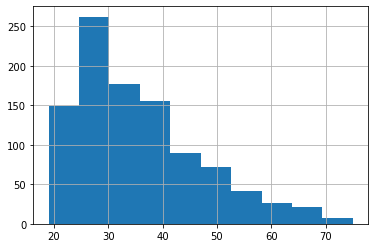

In [7]:
data['Age'].hist()

In [8]:
continuous_features.append('Age')

##### Sex

In [9]:
data['Sex'].isna().sum()

0

In [10]:
data['Sex'].value_counts()

male      690
female    310
Name: Sex, dtype: int64

In [11]:
data['Sex'].unique()

array(['male', 'female'], dtype=object)

In [12]:
data['Sex'] = data['Sex'].map({'male':1, 'female':0})
data

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,own,NaN,little,1169,6,radio/TV
1,22,0,2,own,little,moderate,5951,48,radio/TV
2,49,1,1,own,little,NaN,2096,12,education
3,45,1,2,free,little,little,7882,42,furniture/equipment
4,53,1,2,free,little,little,4870,24,car
...,...,...,...,...,...,...,...,...,...
995,31,0,1,own,little,NaN,1736,12,furniture/equipment
996,40,1,3,own,little,little,3857,30,car
997,38,1,2,own,little,NaN,804,12,radio/TV
998,23,1,2,free,little,little,1845,45,radio/TV


##### Job

In [13]:
data['Job'].isna().sum()

0

In [14]:
data['Job'].unique()

array([2, 1, 3, 0], dtype=int64)

Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled). Obviously, this variable is categorial one. However, we can determine order (it has been already determined). Indeed, 3 > 2 > 1 > 0 and highly skilled person is better than a skilled one, the last is better than an unskilled person and resident and the worst case is an unskilled and non-resident. So we try two options. the first one consider these variables as the categorial ones, and the second one deals with variables with order  

In [15]:
data['Job'].value_counts()

2    630
1    200
3    148
0     22
Name: Job, dtype: int64

In [16]:
data['Non-resident'] = (data['Job'] == 0).map({True:1, False:0})
data['Unskilled'] = (data['Job'] == 1).map({True:1, False:0})
data['Skilled'] = (data['Job'] == 2).map({True:1, False:0})
data['Highly Skilled'] = (data['Job'] == 3).map({True:1, False:0})

##### Housing

In [17]:
data['Housing'].isna().sum()

0

In [18]:
data['Housing'].unique()

array(['own', 'free', 'rent'], dtype=object)

In [19]:
data['Housing'].value_counts()

own     713
rent    179
free    108
Name: Housing, dtype: int64

In [20]:
for i in data['Housing'].unique():
    data["Housing_" + str(i)] = (data['Housing'] == i).map({True:1, False: 0})

In [21]:
data['Housing'] = data['Housing'].map({'own': 2, 'rent': 1, 'free': 0})
data.head(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Non-resident,Unskilled,Skilled,Highly Skilled,Housing_own,Housing_free,Housing_rent
0,67,1,2,2,NaN,little,1169,6,radio/TV,0,0,1,0,1,0,0
1,22,0,2,2,little,moderate,5951,48,radio/TV,0,0,1,0,1,0,0
2,49,1,1,2,little,NaN,2096,12,education,0,1,0,0,1,0,0
3,45,1,2,0,little,little,7882,42,furniture/equipment,0,0,1,0,0,1,0
4,53,1,2,0,little,little,4870,24,car,0,0,1,0,0,1,0


##### Saving accounts

In [22]:
data['Saving accounts'].isna().sum()

183

In [23]:
data['Saving accounts'].unique()

array([nan, 'little', 'quite rich', 'rich', 'moderate'], dtype=object)

In [24]:
data['Saving accounts'].value_counts()

little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

We can assume the following. If we don't have information about saving account of a customer, then the customer is not client of our bank. If he/she asks credit then we should be suspicious, why does he/she ask credit in our bank, not in his/her bank? Maybe, he/she has debts in her/his bank. There can be several options. A person without account is young, then it is strange if he/she ask credit at once. These persons have no life experience then a change of mistake is high. If such persons are old, then they must have account in other bank, but why don't they ask credit in their bank? Maybe, we have more comfortable credit conditions. Anyway, I would not trust such persons, then nan < little < moderate < quite rich < rich

In [25]:
for i in data['Saving accounts'].unique():
    data["SA_" + str(i)] = (data['Saving accounts'] == i).map({True:1, False: 0})

In [26]:
data['Saving accounts'] = data['Saving accounts'].fillna('unknown')
data['Saving accounts'] = data['Saving accounts'].map({'unknown': -1, 'little': 0, 'moderate': 1, 'quite rich': 2, 'rich': 3})

In [27]:
data.head(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Non-resident,...,Skilled,Highly Skilled,Housing_own,Housing_free,Housing_rent,SA_nan,SA_little,SA_quite rich,SA_rich,SA_moderate
0,67,1,2,2,-1,little,1169,6,radio/TV,0,...,1,0,1,0,0,0,0,0,0,0
1,22,0,2,2,0,moderate,5951,48,radio/TV,0,...,1,0,1,0,0,0,1,0,0,0
2,49,1,1,2,0,NaN,2096,12,education,0,...,0,0,1,0,0,0,1,0,0,0
3,45,1,2,0,0,little,7882,42,furniture/equipment,0,...,1,0,0,1,0,0,1,0,0,0
4,53,1,2,0,0,little,4870,24,car,0,...,1,0,0,1,0,0,1,0,0,0


##### Checking account

In [28]:
data['Checking account'].isna().sum()

394

In [29]:
data['Checking account'].unique()

array(['little', 'moderate', nan, 'rich'], dtype=object)

In [30]:
data['Checking account'].value_counts()

little      274
moderate    269
rich         63
Name: Checking account, dtype: int64

In [31]:
for i in data['Checking account'].unique():
    data["CA_" + str(i)] = (data['Checking account'] == i).map({True:1, False: 0})

In [32]:
data['Checking account'] = data['Checking account'].fillna('unknown')
data['Checking account'] = data['Checking account'].map({'unknown': -1, 'little': 0, 'moderate': 1, 'rich': 3})
data.head(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Non-resident,...,Housing_rent,SA_nan,SA_little,SA_quite rich,SA_rich,SA_moderate,CA_little,CA_moderate,CA_nan,CA_rich
0,67,1,2,2,-1,0,1169,6,radio/TV,0,...,0,0,0,0,0,0,1,0,0,0
1,22,0,2,2,0,1,5951,48,radio/TV,0,...,0,0,1,0,0,0,0,1,0,0
2,49,1,1,2,0,-1,2096,12,education,0,...,0,0,1,0,0,0,0,0,0,0
3,45,1,2,0,0,0,7882,42,furniture/equipment,0,...,0,0,1,0,0,0,1,0,0,0
4,53,1,2,0,0,0,4870,24,car,0,...,0,0,1,0,0,0,1,0,0,0


##### Credit amount

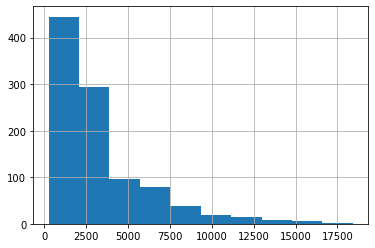

In [33]:
data['Credit amount'].hist()

In [34]:
continuous_features.append('Credit amount')

##### Duration

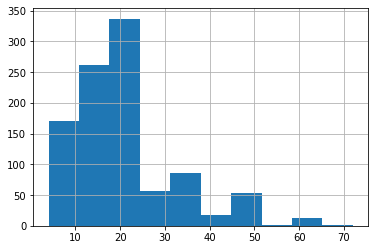

In [35]:
data['Duration'].hist()

In [36]:
continuous_features.append('Duration')

##### Purpose

In [37]:
data['Purpose'].isna().sum()

0

In [38]:
data['Purpose'].unique()

array(['radio/TV', 'education', 'furniture/equipment', 'car', 'business',
       'domestic appliances', 'repairs', 'vacation/others'], dtype=object)

In [39]:
data['Purpose'].value_counts()

car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: Purpose, dtype: int64

In [40]:
for i in data['Purpose'].unique():
    if (i != 0):
        name = str(i)
        data[name] = data['Purpose'] == i
        data[name] = data[name].map({True: 1, False: 0})

In [41]:
data.head(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Non-resident,...,CA_nan,CA_rich,radio/TV,education,furniture/equipment,car,business,domestic appliances,repairs,vacation/others
0,67,1,2,2,-1,0,1169,6,radio/TV,0,...,0,0,1,0,0,0,0,0,0,0
1,22,0,2,2,0,1,5951,48,radio/TV,0,...,0,0,1,0,0,0,0,0,0,0
2,49,1,1,2,0,-1,2096,12,education,0,...,0,0,0,1,0,0,0,0,0,0
3,45,1,2,0,0,0,7882,42,furniture/equipment,0,...,0,0,0,0,1,0,0,0,0,0
4,53,1,2,0,0,0,4870,24,car,0,...,0,0,0,0,0,1,0,0,0,0


##### Correlations

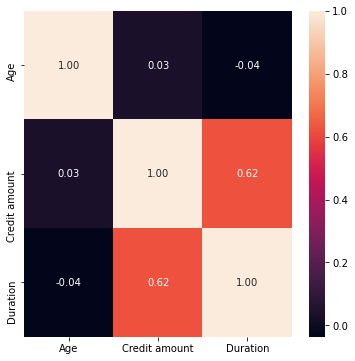

In [42]:
corr = data[continuous_features].corr()
plt.figure(figsize=(6,6))
sns.heatmap(corr, annot=True, fmt='.2f')

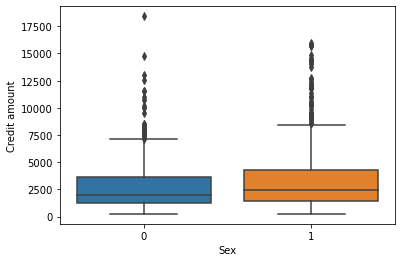

In [43]:
sns.boxplot (data = data, x = 'Sex', y = 'Credit amount')

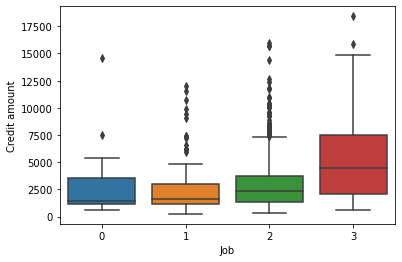

In [44]:
sns.boxplot (data = data, x = 'Job', y = 'Credit amount')

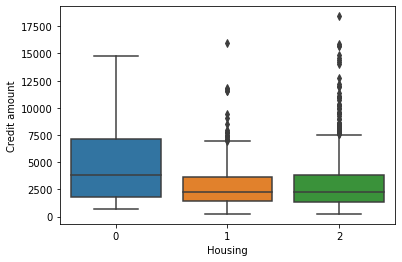

In [45]:
sns.boxplot (data = data, x = 'Housing', y = 'Credit amount')

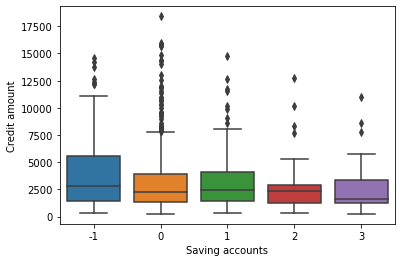

In [46]:
sns.boxplot (data = data, x = 'Saving accounts', y = 'Credit amount')

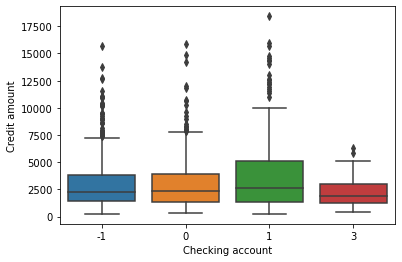

In [47]:
sns.boxplot (data = data, x = 'Checking account', y = 'Credit amount')

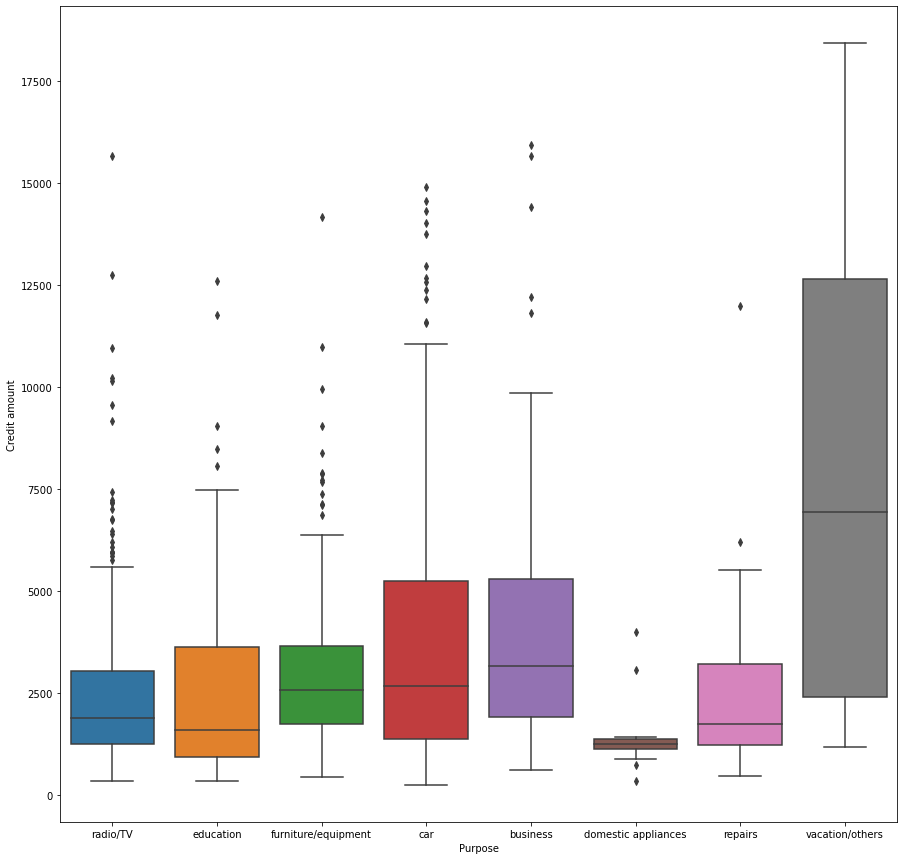

In [48]:
plt.figure(figsize=(15,15))
sns.boxplot (data = data, x = 'Purpose', y = 'Credit amount')

In [49]:
data.drop(["Purpose"], axis = 1, inplace = True)

## Preprocessing

In [50]:
data.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Non-resident', 'Unskilled', 'Skilled',
       'Highly Skilled', 'Housing_own', 'Housing_free', 'Housing_rent',
       'SA_nan', 'SA_little', 'SA_quite rich', 'SA_rich', 'SA_moderate',
       'CA_little', 'CA_moderate', 'CA_nan', 'CA_rich', 'radio/TV',
       'education', 'furniture/equipment', 'car', 'business',
       'domestic appliances', 'repairs', 'vacation/others'],
      dtype='object')

Because we work with distances here. So to avoid situation when features with bigger possible range have bigger influence on the total result, we should scale features

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[continuous_features] = scaler.fit_transform(data[continuous_features])
data.head(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Non-resident,Unskilled,...,CA_nan,CA_rich,radio/TV,education,furniture/equipment,car,business,domestic appliances,repairs,vacation/others
0,2.766456,1,2,2,-1,0,-0.745131,-1.236478,0,0,...,0,0,1,0,0,0,0,0,0,0
1,-1.191404,0,2,2,0,1,0.949817,2.248194,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1.183312,1,1,2,0,-1,-0.416562,-0.738668,0,1,...,0,0,0,1,0,0,0,0,0,0
3,0.831502,1,2,0,0,0,1.634247,1.750384,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1.535122,1,2,0,0,0,0.566664,0.256953,0,0,...,0,0,0,0,0,1,0,0,0,0


Because we decided that Job, Housing, Saving and Checking accounts have order, we can scale them too

In [52]:
columns = ['Job', 'Housing', 'Saving accounts', 'Checking account']
data[columns] = scaler.fit_transform(data[columns])
data.head(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Non-resident,Unskilled,...,CA_nan,CA_rich,radio/TV,education,furniture/equipment,car,business,domestic appliances,repairs,vacation/others
0,2.766456,1,0.146949,0.585603,-1.231393,-0.057803,-0.745131,-1.236478,0,0,...,0,0,1,0,0,0,0,0,0,0
1,-1.191404,0,0.146949,0.585603,-0.196609,0.845372,0.949817,2.248194,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1.183312,1,-1.383771,0.585603,-0.196609,-0.960978,-0.416562,-0.738668,0,1,...,0,0,0,1,0,0,0,0,0,0
3,0.831502,1,0.146949,-2.379476,-0.196609,-0.057803,1.634247,1.750384,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1.535122,1,0.146949,-2.379476,-0.196609,-0.057803,0.566664,0.256953,0,0,...,0,0,0,0,0,1,0,0,0,0


In [53]:
data.drop(['Non-resident', 'Unskilled', 'Skilled',
       'Highly Skilled', 'Housing_own', 'Housing_free', 'Housing_rent',
       'SA_nan', 'SA_little', 'SA_quite rich', 'SA_rich', 'SA_moderate',
       'CA_little', 'CA_moderate', 'CA_nan', 'CA_rich', 'radio/TV',
       'education', 'furniture/equipment', 'car', 'business',
       'domestic appliances', 'repairs', 'vacation/others'], axis = 1, inplace = True)

## Clustering

#### K-Means

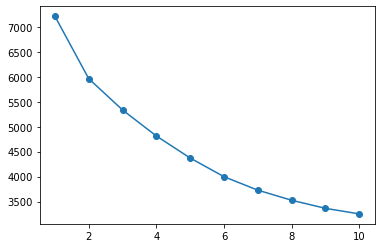

In [54]:
inertia = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i).fit(data)
    inertia_i = kmeans.inertia_
    inertia.append(inertia_i)
plt.plot(range(1,11), inertia, marker='o')

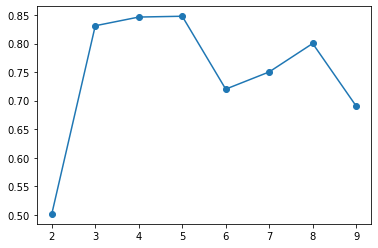

In [55]:
D = []
for i in range(1,9):
    Di = (inertia[i] - inertia[i+1]) / (inertia[i-1] - inertia[i])
    D.append(Di)
plt.plot(range(2,10), D, marker='o');

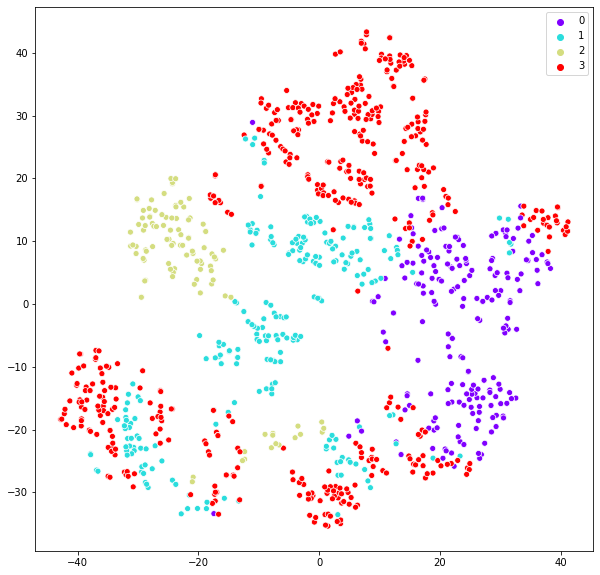

In [56]:
kmeans = KMeans(n_clusters=4).fit(data)
labels = kmeans.labels_
tsne = TSNE(n_components=2)
data_tsne = tsne.fit_transform(data)
plt.figure(figsize=(10,10))
sns.scatterplot(data_tsne[:,0], data_tsne[:,1],hue=labels, palette='rainbow')


In [57]:
score = silhouette_score(data, labels)
score

0.16104862023564118

##### Agglomerative Clustering

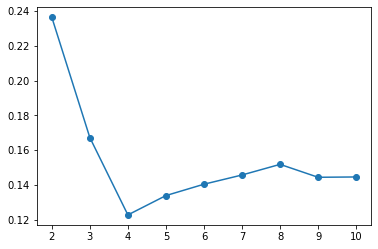

In [58]:
silhouette = []
for i in range(2,11):
    agg = AgglomerativeClustering(n_clusters=i).fit(data)
    labels = agg.labels_
    score = silhouette_score(data, labels)
    silhouette.append(score)
plt.plot(range(2,11), silhouette, marker='o');

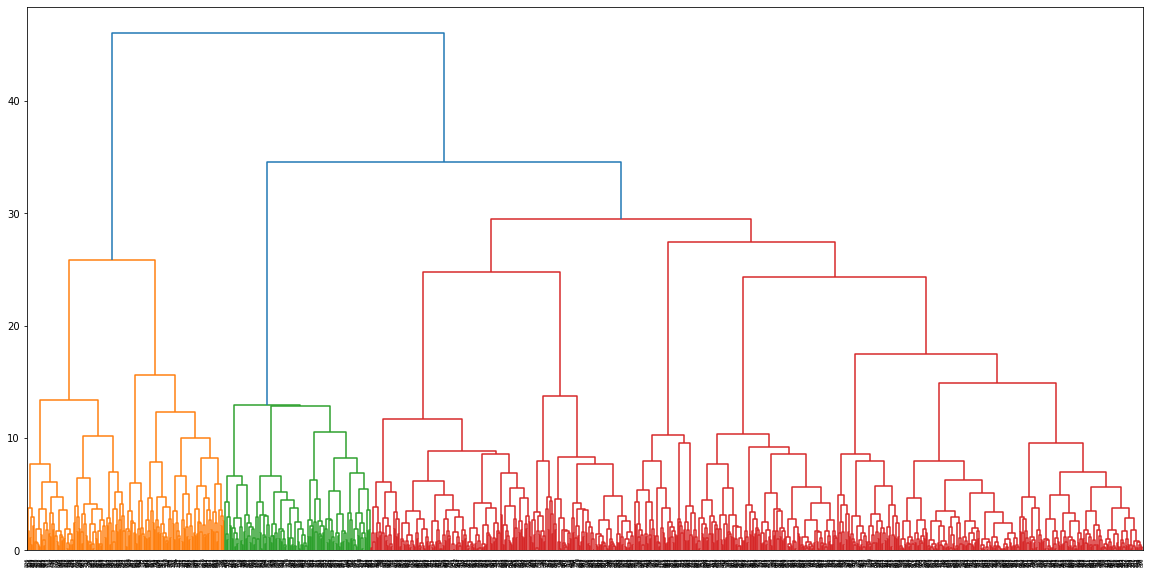

In [59]:
plt.figure(figsize=(20,10))
linkage_ = linkage(data, method='ward')
dendrogram_ = dendrogram(linkage_)

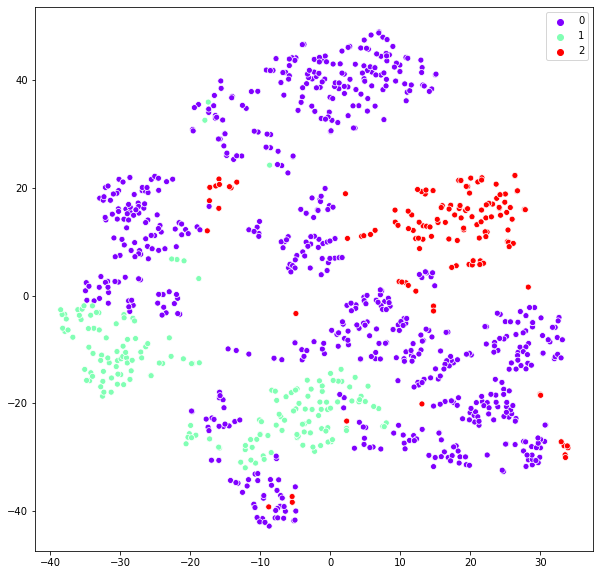

In [60]:
agg = AgglomerativeClustering(n_clusters=3).fit(data)
labels = agg.labels_
tsne = TSNE(n_components=2)
data_tsne = tsne.fit_transform(data)
plt.figure(figsize=(10,10))
sns.scatterplot(data_tsne[:,0], data_tsne[:,1],hue=labels, palette='rainbow')

##### DBSCAN

In [61]:
silhouette = []
for i in np.arange(1.3, 1.6, 0.05):
    current_silouette = []
    for j in np.arange(1, 10, 1):
        dbscan = DBSCAN(eps=i, min_samples=j).fit(data)
        labels = dbscan.labels_
        if (len(np.unique(labels)) > 3):
            current_silouette.append(silhouette_score(data, labels))
        elif (len(np.unique(labels)) > 1):
            current_silouette.append(-1)
        else:
            current_silouette.append(0)
    silhouette.append(current_silouette)

In [62]:
silhouette

[[-0.07531554353889963,
  -0.058200193199830254,
  -0.05124548668214277,
  -0.02989889288007224,
  -0.012042766730112566,
  -0.013931723631040522,
  -0.021315738864023482,
  -0.0059067220914606,
  -0.0033328840982905783],
 [-0.07589371702825348,
  -0.05207224607054469,
  -0.04710202869365152,
  -0.019771138154064158,
  0.0032465267589364224,
  -0.007224281790178784,
  -0.016102224050308984,
  -0.01768369690042194,
  -0.002938748060175983],
 [-0.07767556999648818,
  -0.04707649077557153,
  -0.029484064418918876,
  -0.011764700520446043,
  0.012530809258966739,
  0.006883676151192523,
  -0.0026171527766275463,
  -0.0015312592107426149,
  -0.0102774037625332],
 [-0.07559902017189783,
  -0.022547384113413314,
  -0.004948762138075328,
  -0.009607140152604516,
  0.02011253410404224,
  0.019391028419040886,
  0.014000736913770392,
  0.009931741605624746,
  -0.0004666471711385687],
 [-0.11973209176464893,
  -0.06584599550312738,
  -0.03382250592135679,
  -0.04562234662986707,
  -0.013624898372

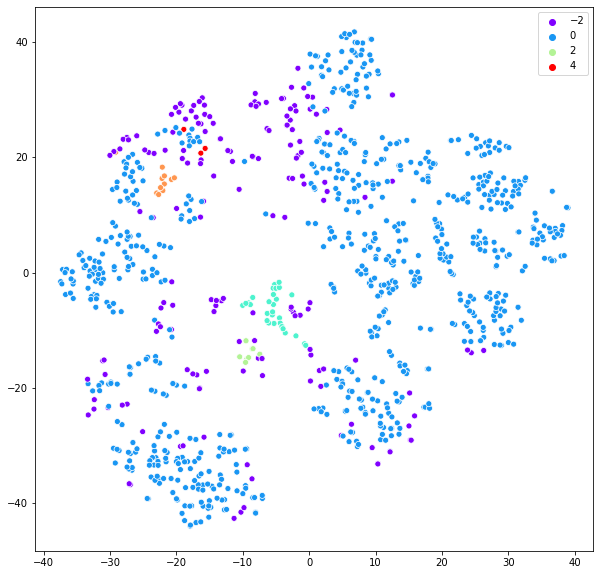

In [63]:
dbscan = DBSCAN(eps=1.55, min_samples=5).fit(data)
labels = dbscan.labels_
tsne = TSNE(n_components=2)
data_tsne = tsne.fit_transform(data)
plt.figure(figsize=(10,10))
sns.scatterplot(data_tsne[:,0], data_tsne[:,1],hue=labels, palette='rainbow')

##### Resume 

After all attempts to find out the best parameters of DBSCAN, agglomerattive clustering shows the best result. So, let's use it 

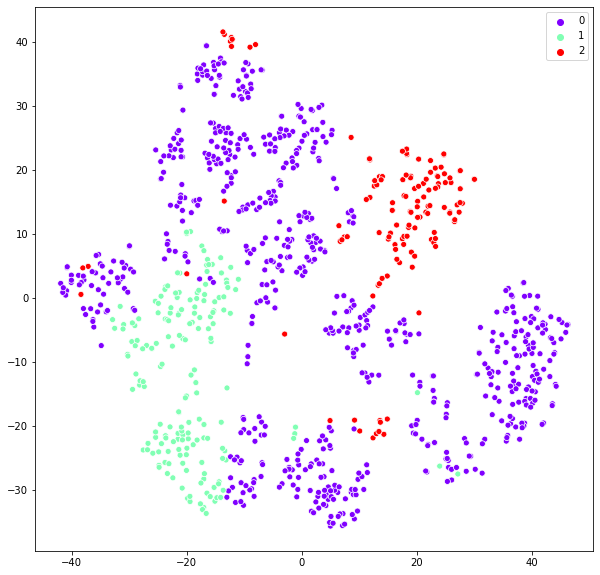

In [64]:
agg = AgglomerativeClustering(n_clusters=3).fit(data)
labels = agg.labels_
tsne = TSNE(n_components=2)
data_tsne = tsne.fit_transform(data)
plt.figure(figsize=(10,10))
sns.scatterplot(data_tsne[:,0], data_tsne[:,1],hue=labels, palette='rainbow')

In [65]:
data['labels'] = labels

In [66]:
data

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,labels
0,2.766456,1,0.146949,0.585603,-1.231393,-0.057803,-0.745131,-1.236478,0
1,-1.191404,0,0.146949,0.585603,-0.196609,0.845372,0.949817,2.248194,1
2,1.183312,1,-1.383771,0.585603,-0.196609,-0.960978,-0.416562,-0.738668,0
3,0.831502,1,0.146949,-2.379476,-0.196609,-0.057803,1.634247,1.750384,1
4,1.535122,1,0.146949,-2.379476,-0.196609,-0.057803,0.566664,0.256953,1
...,...,...,...,...,...,...,...,...,...
995,-0.399832,0,-1.383771,0.585603,-0.196609,-0.960978,-0.544162,-0.738668,0
996,0.391740,1,1.677670,0.585603,-0.196609,-0.057803,0.207612,0.754763,0
997,0.215835,1,0.146949,0.585603,-0.196609,-0.960978,-0.874503,-0.738668,0
998,-1.103451,1,0.146949,-2.379476,-0.196609,-0.057803,-0.505528,1.999289,1


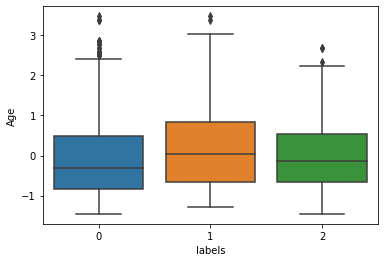

In [67]:
sns.boxplot (data = data, x = 'labels', y = 'Age')

In [68]:
data[data['labels'] == 0].describe()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,labels
count,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.0
mean,-0.059334,0.661850,-0.125130,0.133557,-0.304274,0.042695,-0.291368,-0.321068,0.0
std,0.983956,0.473422,1.030444,0.833979,0.581896,1.045778,0.610420,0.662983,0.0
min,-1.455261,0.000000,-2.914492,-2.379476,-1.231393,-0.960978,-1.061649,-1.402415,0.0
25%,-0.839594,0.000000,-1.383771,-0.896936,-0.196609,-0.960978,-0.708181,-0.738668,0.0
50%,-0.311879,1.000000,0.146949,0.585603,-0.196609,-0.057803,-0.472210,-0.489762,0.0
75%,0.479693,1.000000,0.146949,0.585603,-0.196609,0.845372,-0.025434,0.256953,0.0
max,3.470076,1.000000,1.677670,0.585603,1.872960,2.651721,4.120313,2.248194,0.0


In [69]:
data[data['labels'] == 1].describe()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,labels
count,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.0
mean,0.216332,0.785311,0.449634,-0.737794,-0.278456,0.054456,1.394265,1.450854,1.0
std,1.062920,0.411771,0.909101,1.363909,0.710152,0.755851,1.278900,1.016730,0.0
min,-1.279356,0.000000,-2.914492,-2.379476,-1.231393,-0.960978,-0.746904,-1.070541,1.0
25%,-0.663689,1.000000,0.146949,-2.379476,-0.196609,-0.960978,0.389442,0.754763,1.0
50%,0.039930,1.000000,0.146949,-0.896936,-0.196609,-0.057803,1.309931,1.252574,1.0
75%,0.831502,1.000000,1.677670,0.585603,-0.196609,0.845372,2.171583,2.248194,1.0
max,3.470076,1.000000,1.677670,0.585603,2.907744,2.651721,5.370789,4.239436,1.0


In [70]:
data[data['labels'] == 2].describe()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,labels
count,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.0
mean,0.021131,0.709924,0.053470,0.291359,1.983547,-0.299109,-0.344721,-0.264291,2.0
std,0.966247,0.455539,0.753630,0.745134,0.804125,1.000882,0.528159,0.686514,0.0
min,-1.455261,0.000000,-2.914492,-2.379476,0.838175,-0.960978,-1.070865,-1.236478,2.0
25%,-0.663689,0.000000,0.146949,0.585603,1.355567,-0.960978,-0.692674,-0.738668,2.0
50%,-0.135974,1.000000,0.146949,0.585603,1.872960,-0.960978,-0.452361,-0.489762,2.0
75%,0.523669,1.000000,0.146949,0.585603,2.907744,-0.057803,-0.155869,0.256953,2.0
max,2.678504,1.000000,1.677670,0.585603,2.907744,2.651721,1.893345,1.750384,2.0


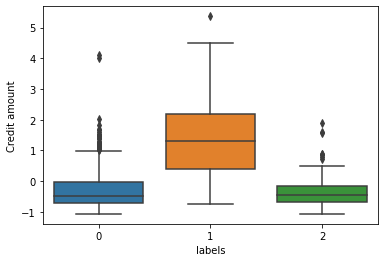

In [71]:
sns.boxplot (data = data, x = 'labels', y = 'Credit amount')

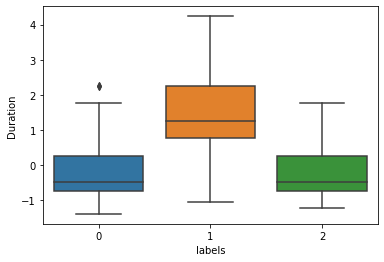

In [72]:
sns.boxplot (data = data, x = 'labels', y = 'Duration')

The group with label '1' are the ones who prefer to take long-term big credit with the best jobs. The group with label '2' is medium job people with good bank account history and medium job, and the rest group  has bad account history and low qulified job. 